## Training a GPT-2 model on peptide sequences

[Theis et al. (2016)](https://arxiv.org/abs/1511.01844) show that the (negative) log-likelihood (which is used to train many machine learning models) is not a sufficient criteria to decide whether a model training should terminate. Thus, in this notebook, we show how to use seqme's metrics to determine model training stopping criteria. Several models [REF: dirichet flow, MOG] use the FBD as stopping criteria.

In [1]:
# !pip install datasets transformers[torch] "seqme[hyformer]" "hyformer @ git+https://github.com/szczurek-lab/hyformer.git@v2.0"

In [2]:
%load_ext autoreload
%autoreload 2

import random
from functools import partial
from pathlib import Path
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
from datasets import Dataset, DatasetDict
from transformers import (
    GPT2Config,
    GPT2LMHeadModel,
    Trainer,
    TrainingArguments,
)

import seqme as sm


In [3]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False


In [4]:
set_seed(42)

In [5]:
WORKDIR_PATH = Path("./..")

In [6]:
DATA_PATH = WORKDIR_PATH / "data" / "gpt2" / "ampsphere_10_50_836941.fasta"

In [7]:
sequences = sm.read_fasta(DATA_PATH)
sequences = sm.utils.subsample(sequences, n_samples=400_000)

In [8]:
train, val = sklearn.model_selection.train_test_split(sequences, train_size=0.99)

In [9]:
len(train), len(val)

(396000, 4000)

In [10]:
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")  # 20 canonical AAs
special_tokens = ["<pad>", "<bos>", "<eos>"]
vocab_list = special_tokens + amino_acids

vocab = {ch: i for i, ch in enumerate(vocab_list)}
inv_vocab = {i: ch for ch, i in vocab.items()}
vocab_size = len(vocab_list)


def tokenize_sequence(ex):
    seq = ex["text"].strip()
    tokens = [vocab["<bos>"]] + [vocab[ch] for ch in seq] + [vocab["<eos>"]]
    return {"input_ids": tokens, "labels": tokens}


def collate_batch(batch, pad_id=vocab["<pad>"], max_len: int = 64):
    input_ids = [x["input_ids"][:max_len] for x in batch]
    labels = [x["labels"][:max_len] for x in batch]

    # pad sequences
    max_batch_len = max(len(x) for x in input_ids)
    input_ids = [x + [pad_id] * (max_batch_len - len(x)) for x in input_ids]
    labels = [x + [-100] * (max_batch_len - len(x)) for x in labels]  # ignore pad in loss

    attention_mask = [[1] * len(x) + [0] * (max_batch_len - len(x)) for x in input_ids]

    return {
        "input_ids": torch.tensor(input_ids, dtype=torch.long),
        "labels": torch.tensor(labels, dtype=torch.long),
        "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
    }


In [11]:
ds_train = Dataset.from_dict({"text": train})
ds_valid = Dataset.from_dict({"text": val})
ds = DatasetDict({"train": ds_train, "validation": ds_valid})

tok_ds = ds.map(tokenize_sequence, remove_columns=["text"])

In [12]:
def decode(seq, inv_vocab=inv_vocab, pad=vocab["<pad>"], bos=vocab["<bos>"], eos=vocab["<eos>"]) -> str:
    """Decode a single sequence of token IDs into a string."""
    decoded = []
    for i, tok in enumerate(seq):
        tok = int(tok)
        if tok == pad:
            continue
        if i == 0 and tok == bos:
            continue
        if tok == eos:
            break
        decoded.append(inv_vocab[tok])
    return "".join(decoded)

In [13]:
@torch.inference_mode()
def generate(
    model,
    n_samples: int,
    *,
    max_length=52,
    top_k: int = 5,
    top_p: float = 0.9,
    batch_size: int = 256,
) -> list[str]:
    BOS_TOKEN = vocab["<bos>"]
    input_ids = torch.tensor([[BOS_TOKEN]] * n_samples, dtype=torch.long, device=model.device)

    output = []
    for i in range(0, n_samples, batch_size):
        batch = input_ids[i : i + batch_size]
        output_ids = model.generate(
            input_ids=batch,
            max_length=max_length,
            do_sample=True,
            top_k=top_k,
            top_p=top_p,
            pad_token_id=vocab["<pad>"],
        )
        outs = [decode(seq) for seq in output_ids]
        output += outs

    return output


In [14]:
model = GPT2LMHeadModel(
    GPT2Config(
        vocab_size=vocab_size,
        n_positions=64,
        n_embd=480,
        n_layer=6,
        n_head=6,
    )
)

print("Total parameters:", sum(p.numel() for p in model.parameters()))
print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Total parameters: 16668960
Trainable parameters: 16668960


In [15]:
n_sequences = 2048
dfs = []

hyformer = sm.models.Hyformer(sm.models.HyformerCheckpoint.peptides_34M)
#hyformer_mic = sm.models.Hyformer(sm.models.HyformerCheckpoint.peptides_34M_mic)

metrics = [
    sm.metrics.Uniqueness(),
    sm.metrics.FBD(val, hyformer),
    sm.metrics.MMD(val, hyformer, device="cuda"),
    sm.metrics.Recall(n_neighbors=5, reference=val, embedder=hyformer, strict=False, device="cuda"),
    sm.metrics.Precision(n_neighbors=5, reference=val, embedder=hyformer, strict=False, device="cuda"),
    #sm.metrics.ID(hyformer_mic.predict, "log MIC", "minimize"),
]


def compute_metrics(eval_pred):
    sequences = partial(generate, model)(n_sequences)

    row_name = ("GPT-2", len(dfs))
    df = sm.evaluate({row_name: sequences}, metrics, verbose=False)
    dfs.append(df)

    return {f"val/{metric.name}": df[(metric.name, "value")][row_name] for metric in metrics}

Model weights loaded from SzczurekLab/hyformer_peptides_34M


/home/icb/rasmus.larsen/tools/apps/miniconda3/envs/seqme_env/lib/python3.11/site-packages/hyformer/models/utils/state_dict_utils.py:29: UserWarning: Model is not compiled but state dict is. Removing prefix from state dict.
  warnings.warn("Model is not compiled but state dict is. Removing prefix from state dict.")


Model state_dict loaded with `strict=False`. Missing keys: [], Unexpected keys: ['prediction_head.dense.weight', 'prediction_head.dense.bias', 'prediction_head.out_proj.weight', 'prediction_head.out_proj.bias']


In [ ]:
training_args = TrainingArguments(
    output_dir="./peptide_gpt_small",
    overwrite_output_dir=True,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    num_train_epochs=600,
    learning_rate=4e-5,
    eval_strategy="steps",
    eval_steps=1000,
    save_strategy="epoch",
    logging_steps=1000,
    report_to="none",
    torch_compile=True,
    # fp16=False,
    # use_cpu=True,
    #save_steps=50_000,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tok_ds["train"],
    eval_dataset=tok_ds["validation"],
    data_collator=collate_batch,
    compute_metrics=compute_metrics,
)

trainer.train()


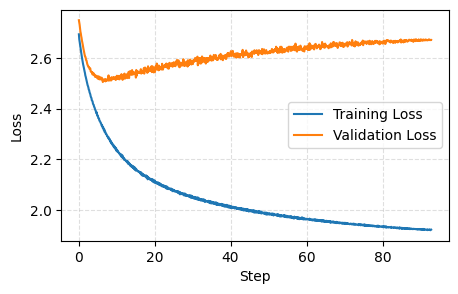

In [18]:
train_loss = [(dv["step"], dv["loss"]) for dv in trainer.state.log_history if "loss" in dv]
val_loss = [(dv["step"], dv["eval_loss"]) for dv in trainer.state.log_history if "eval_loss" in dv]

train_steps, train_values = zip(*train_loss, strict=True)
val_steps, val_values = zip(*val_loss, strict=True)

val_steps = np.array(val_steps) / 10_000
train_steps = np.array(train_steps) / 10_000

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(train_steps, train_values, label="Training Loss")
ax.plot(val_steps, val_values, label="Validation Loss")
ax.set_xlabel("Step")
ax.set_ylabel("Loss")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.4)
plt.show()

In [19]:
df_all = sm.combine(dfs)

In [36]:
sm.to_pickle(df_all, "gpt2.pkl")

In [20]:
df_all.index = pd.MultiIndex.from_arrays([df_all.index.get_level_values(0), val_steps])

In [21]:
def insert(df: pd.DataFrame, name: str, values: np.ndarray, objective: Literal["minimize", "maximize"]) -> pd.DataFrame:
    df = df.copy()
    df[(name, "value")] = values
    df[(name, "deviation")] = float("nan")
    df.attrs["objective"][name] = objective
    return df

In [22]:
df_all = insert(df_all, "Perplexity", np.exp(val_values), "minimize")

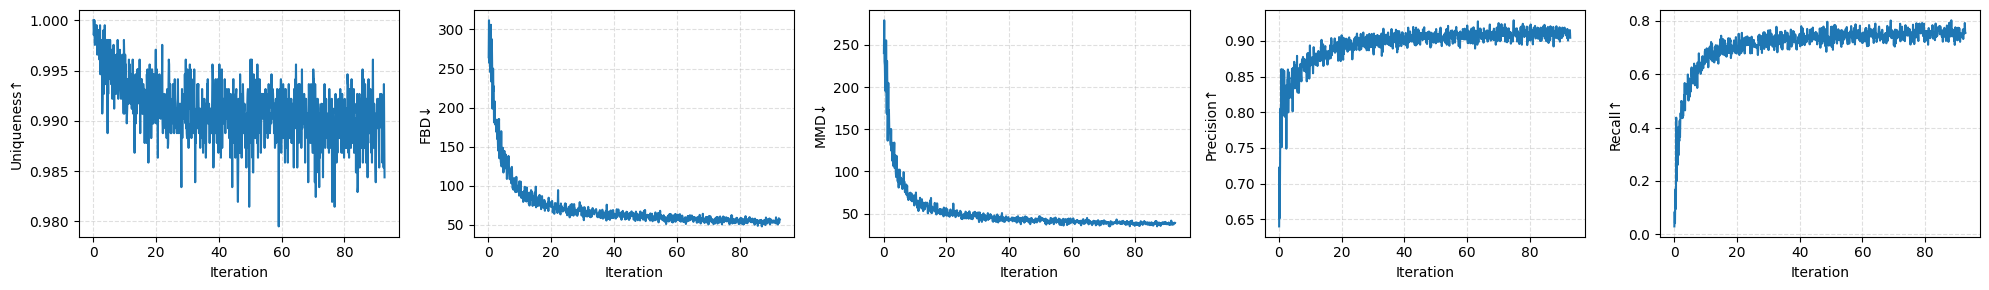

In [23]:
metrics_to_show = ["Uniqueness", "FBD", "MMD", "Precision", "Recall"]

fig, axes = plt.subplots(nrows=1, ncols=len(metrics_to_show), figsize=(len(metrics_to_show) * 4, 3))

for i, name in enumerate(metrics_to_show):
    sm.plot_line(df_all, metric=name, ax=axes[i], marker=None)
    axes[i].get_legend().remove()

fig.tight_layout()

In [24]:
cmap = plt.get_cmap("viridis")
K = len(df_all)
colors = [cmap(i / (K - 1)) for i in range(K)]

df_flat = df_all.xs("GPT-2", level=0)

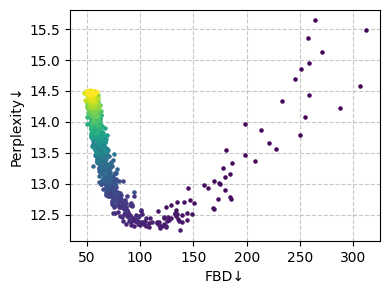

In [25]:
fig, ax = plt.subplots(figsize=(4,3))
sm.plot_scatter(df_flat, ["FBD", "Perplexity"], marker_size=5, ax=ax, color=colors)
ax.get_legend().remove()

In [26]:
df_all = sm.rank(df_all, metrics=["MMD", "Recall", "Precision"])

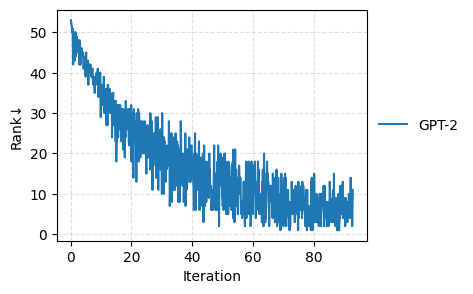

In [27]:
sm.plot_line(df_all, metric="Rank", marker=None)

In [28]:
N_SAMPLES = 1_000

generated_sequences = generate(model, n_samples=N_SAMPLES, max_length=50)

In [29]:
for peptide in generated_sequences:
    print(len(peptide), peptide)

32 GIAGGKAAFTSRRSRSRKTAKVSKAAGGKLRP
40 IIGVAIKRNIGKGKYLIQADDVIDREFIRIADRLHGVKIL
25 IIALLILLFPLSVRKEIEAALFKER
42 IIAAVGKASAISTGSGSLNFRKVSRATIMSRKVNAATIRTAG
32 IVVGARGVGGFLLLMCRVQFSITVISRHGTAR
39 VAIGRKLGKATLGKLKEWGQVRPEGGARGAARLLEGYRF
39 AVAAVAVAAAVAVRKSSGSDDLQCRLHVMWKRLGRKKEK
39 GGGGGGGGGRGGGGGGGGGGGGGGGGGGGGGGGVVAFIY
37 LGVLGLGLQGQLDLKHLGRVLGLELGLKLLGLLGLKS
37 GGGLGARIDVVGAALRDAIAGNGGGKVIVAGVERGKP
48 LGVGIFALRGGKGVGVGVTVKHVTHFYHIVIGEVTDVLCVGAHGTHQV
42 VLVLKALKAIQVLKVLLVLKVILVLKVLKVTLVQVLKVLKAL
38 AAGAVAGGLAGGLAARRGPGVGKMRRIVAKLAWRAQSV
33 AVIIILAMLAAIVVIGIIGGQLQHRLLRAQKAL
41 IALVGLEKFKKKLFNKLDFKVNPRWLLDENAPFLKGAGVKL
41 IGVALKLKIEKGGLALQLGALGLLEKEERRGSKEAIKAEKL
37 LLLLKEKALLLHALLAKKLQNIIIKQLSILLVLAKVK
41 VLVLVKELIQQRLIDKVLLVLLLRKQLELQVKLVLVMLLIT
35 LLLFVVLVLVLAVVLLLVVLVVAVFVLLLVVAVLL
46 ILLIIKLINLINKIKIKNFKNLKIIKILNIIINNINNKIKIKIKKL
42 VLALLLVVLLVVLWNRHIRRLVLRMDPRARGQLAEAEARRRG
40 VAAVVVTIATGDHTAAAANTVNRLPGRVGDGTWKANTWIT
26 LGGLVGVPIVGAVLAALRRLPVVAAR
32 AIIILIALILAAAIAAFAREAKALLRNALKDK


In [30]:
REFERENCE_PATH = WORKDIR_PATH / "data" / "dbs" / "uniprot" / "uniprot_8_50_70.fasta"

reference_sequences = sm.read_fasta(REFERENCE_PATH)
reference_sequences = sm.utils.subsample(reference_sequences, n_samples=N_SAMPLES)

In [31]:
hyformer_mic = sm.models.Hyformer(sm.models.HyformerCheckpoint.peptides_34M_mic)

Model weights loaded from SzczurekLab/hyformer_peptides_34M_mic


/home/icb/rasmus.larsen/tools/apps/miniconda3/envs/seqme_env/lib/python3.11/site-packages/hyformer/models/utils/state_dict_utils.py:29: UserWarning: Model is not compiled but state dict is. Removing prefix from state dict.
  warnings.warn("Model is not compiled but state dict is. Removing prefix from state dict.")


In [32]:
ampsphere_sequences = sm.utils.subsample(val, n_samples=N_SAMPLES)

In [33]:
data = {
    "GPT-2": generated_sequences,
    "AMPSphere": ampsphere_sequences,
    "UniProt": reference_sequences,
}

embeddings = {name: hyformer(sequences) for name, sequences in data.items()}
embedding_values = list(embeddings.values())

In [34]:
proj = sm.utils.umap(embedding_values)
proj = dict(zip(embeddings.keys(), proj, strict=True))

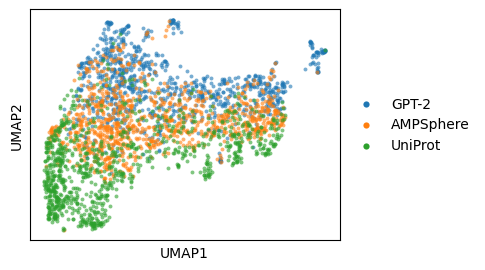

In [35]:
sm.utils.plot_embeddings(
    proj.values(),
    values=proj.keys(),
    xlabel="UMAP1",
    ylabel="UMAP2",
    point_size=8,
)